In [8]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [9]:
# Load Preprocessed Data
train_df = pd.read_csv("cleaned_stock_data_train.csv")
test_df = pd.read_csv("cleaned_stock_data_test.csv")

NameError: name 'pd' is not defined

In [10]:
# Standardize column names
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_')
test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [11]:
# Convert Categorical Columns to Numeric
categorical_cols = train_df.select_dtypes(include=['object']).columns
label_encoders = {}

In [12]:
for col in categorical_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined_data)
    
    train_df[col] = le.transform(train_df[col].astype(str))
    
    # Create a mapping dictionary for test_df transformation
    mapping_dict = {label: index for index, label in enumerate(le.classes_)}
    test_df[col] = test_df[col].astype(str).map(mapping_dict).fillna(-1).astype(int)
    
    label_encoders[col] = le

In [13]:
# Ensure all categorical columns are converted to integers
test_df[categorical_cols] = test_df[categorical_cols].astype(int)
train_df[categorical_cols] = train_df[categorical_cols].astype(int)

In [14]:
# Identify the correct adjusted close column
adj_close_col = [col for col in train_df.columns if 'adj' in col.lower() and 'close' in col.lower()]
if not adj_close_col:
    raise KeyError("❌ No column found for adjusted close price!")
adj_close_col = adj_close_col[0]  # Take the first match


In [20]:
# **Create Classification Target Variable: Price Up (1) / Down (0)**
train_df['price_movement'] = (train_df[adj_close_col].shift(-1) > train_df[adj_close_col]).astype(int)
test_df['price_movement'] = (test_df[adj_close_col].shift(-1) > test_df[adj_close_col]).astype(int)

In [16]:
# Define Features and Target
target = 'price_movement'
features = [col for col in train_df.columns if col not in ['ticker', 'date', 'close', adj_close_col, 'price_movement']]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [17]:
# Initialize Classification Models
models = {
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05, 
        objective='binary:logistic', n_jobs=-1, enable_categorical=True
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05, 
        n_jobs=-1
    )
}

results = {}


2025-03-04 13:49:07,307 - INFO - Training XGBoost model...
2025-03-04 13:49:33,143 - INFO - XGBoost Performance:
 Accuracy: 0.5539


🔹 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65    583022
           1       0.51      0.30      0.38    481681

    accuracy                           0.55   1064703
   macro avg       0.54      0.53      0.51   1064703
weighted avg       0.54      0.55      0.53   1064703



C:\Users\Samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


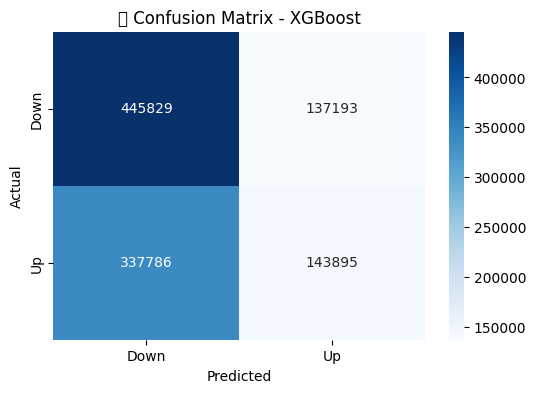

2025-03-04 13:49:33,558 - INFO - Training LightGBM model...


[LightGBM] [Info] Number of positive: 1925321, number of negative: 2333489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4443
[LightGBM] [Info] Number of data points in the train set: 4258810, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452080 -> initscore=-0.192272
[LightGBM] [Info] Start training from score -0.192272


2025-03-04 13:49:54,925 - INFO - LightGBM Performance:
 Accuracy: 0.5537


🔹 LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65    583022
           1       0.51      0.31      0.38    481681

    accuracy                           0.55   1064703
   macro avg       0.54      0.53      0.52   1064703
weighted avg       0.54      0.55      0.53   1064703



C:\Users\Samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


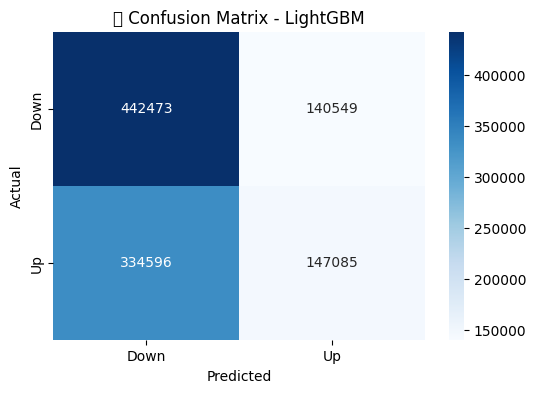

In [18]:
# Train and Evaluate Models
for name, model in models.items():
    logging.info(f"Training {name} model...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {"Accuracy": accuracy}
    logging.info(f"{name} Performance:\n Accuracy: {accuracy:.4f}")
    
    # Display Classification Report
    print(f"🔹 {name} Classification Report:\n", report)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"📊 Confusion Matrix - {name}")
    plt.show()


In [19]:
# Display Results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
display(results_df)



Model Comparison:


,Accuracy
XGBoost,0.553886
LightGBM,0.553730
